In [1]:
#python3
#import libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import os
from auxiliary_functions import *
import seaborn as sns
from scipy.fft import fft, fftfreq
#testing the complex exponential version of this
import cmath
sns.set()
sns.set_style('white')
from scipy.signal import savgol_filter

In [2]:
#-------------BEGIN LOAD DATA-------------------------------------------------------------

for selector in range(3):
	print(selector)
	#set_up_directories
	parent_folder = '/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/paper_outputs/SI_ABM_videos/'
	sub_folders = ['droving_slow', 'mustering_slow', 'driving']
	archived_sub_folders = ['droving', 'mustering']
	change_dir_to = parent_folder + sub_folders[selector]
	os.chdir(change_dir_to)


	#load the parameter files

	L = 6 #size of domain to plot
	dt = 0.05 #manually setting the timestep size (should eventually be grabbed from load_params_auto)

	#start timing
	t0 = time.time()

	#import data files
	dat_field = np.loadtxt('data.txt') #x,y position data for herd and dogs
	#dat_field = np.loadtxt('driving_data_SIVid.txt') #x,y position data for herd and dogs

	#load info from parameter file
	driving_on, x_target, y_target, vs, vd, ls, ld, fence, num_particles, ndogs, modder = load_params_auto('params.txt')

	#load info from data file
	xpart, ypart, thetapart, x_dogs, y_dogs, dat_times, timesteps, times, = load_data(dat_field, num_particles)


	#sanity checks
	sanity_checks(dat_field, num_particles, ndogs, timesteps)

	#temporary function to load the data from the costdata file
	costdata_full_array = np.loadtxt('costdata.txt')
	l4_norm  = costdata_full_array[:,3]



	#-------begin theta extraction----------------------------------

	tComplex = np.zeros((len(thetapart), 2))
	tComplex_avg = np.zeros((timesteps, 2))
	dtComplex_avg = np.zeros((timesteps, 2))
	Theta_extract_avg = np.zeros(timesteps)
	ThetaDot_extract_avg = np.zeros(timesteps)

	#setup complex theta_arrays
	for pp in range(len(thetapart)):
	    tComplex[pp,0] = np.cos(thetapart[pp])
	    tComplex[pp,1] = np.sin(thetapart[pp])

	#take the average of theta over the agents
	for kk in range(timesteps):
	    index = num_particles*kk
	    temp_theta_Complex = tComplex[index:index+num_particles, :]
	    tComplex_avg[kk, :] = np.array([np.average(temp_theta_Complex[:,0]), 
	                                    np.average(temp_theta_Complex[:,1])])
	    dtComplex_avg[kk] = tComplex_avg[kk] - tComplex_avg[kk-1]

	    #extract theta and theta-dot
	    Theta_extract_avg[kk] = np.arctan2(tComplex_avg[kk, 1], tComplex_avg[kk, 0])#%(2*np.pi)
	    
	    ThetaDot_extract_avg[kk] = dtComplex_avg[kk,1]*tComplex_avg[kk, 0]
	    -dtComplex_avg[kk, 0]*tComplex_avg[kk,1]


	filter_Theta_extract_avg = Theta_extract_avg #savgol_filter(Theta_extract_avg, 11, 5)    
	filter_ThetaDot_extract_avg = ThetaDot_extract_avg #savgol_filter(ThetaDot_extract_avg, 11, 5)


	if selector==0:
		#store the good data for use in the combined plots--DROVING ONLY
		droving_theta_1_stored = filter_Theta_extract_avg
		droving_dtheta_1_stored = filter_ThetaDot_extract_avg
	

	elif selector==1:
		#store the good data for use in the combined plots--MUSTERING ONLY
		mustering_theta_1_stored = filter_Theta_extract_avg #np.fmod(-1*Theta_extract_avg[6000:6300], 2*np.pi)
		mustering_dtheta_1_stored = ThetaDot_extract_avg#ThetaDot_extract_avg[6000:6300]


	# store and select the data for each case
	elif selector==2:
		#store the good data for use in the combined plots--MUSTERING ONLY
		driving_theta_1_stored = filter_Theta_extract_avg #Theta_extract_avg[100:300]
		driving_dtheta_1_stored = filter_ThetaDot_extract_avg #ThetaDot_extract_avg[100:300]


	else:
		print("No selector chosen")



0
Looking at data & performing sanity checks...
There are  50 sheep!
There are  1 dogs!
There are 1429 frames of dumped data!
1
Looking at data & performing sanity checks...
There are  100 sheep!
There are  1 dogs!
There are 9759 frames of dumped data!
2
Looking at data & performing sanity checks...
There are  200 sheep!
There are  1 dogs!
There are 1496 frames of dumped data!


must_shift: -0.07831644427261121
drove_shift:  0.0
drive_shift:  2.549153525812439


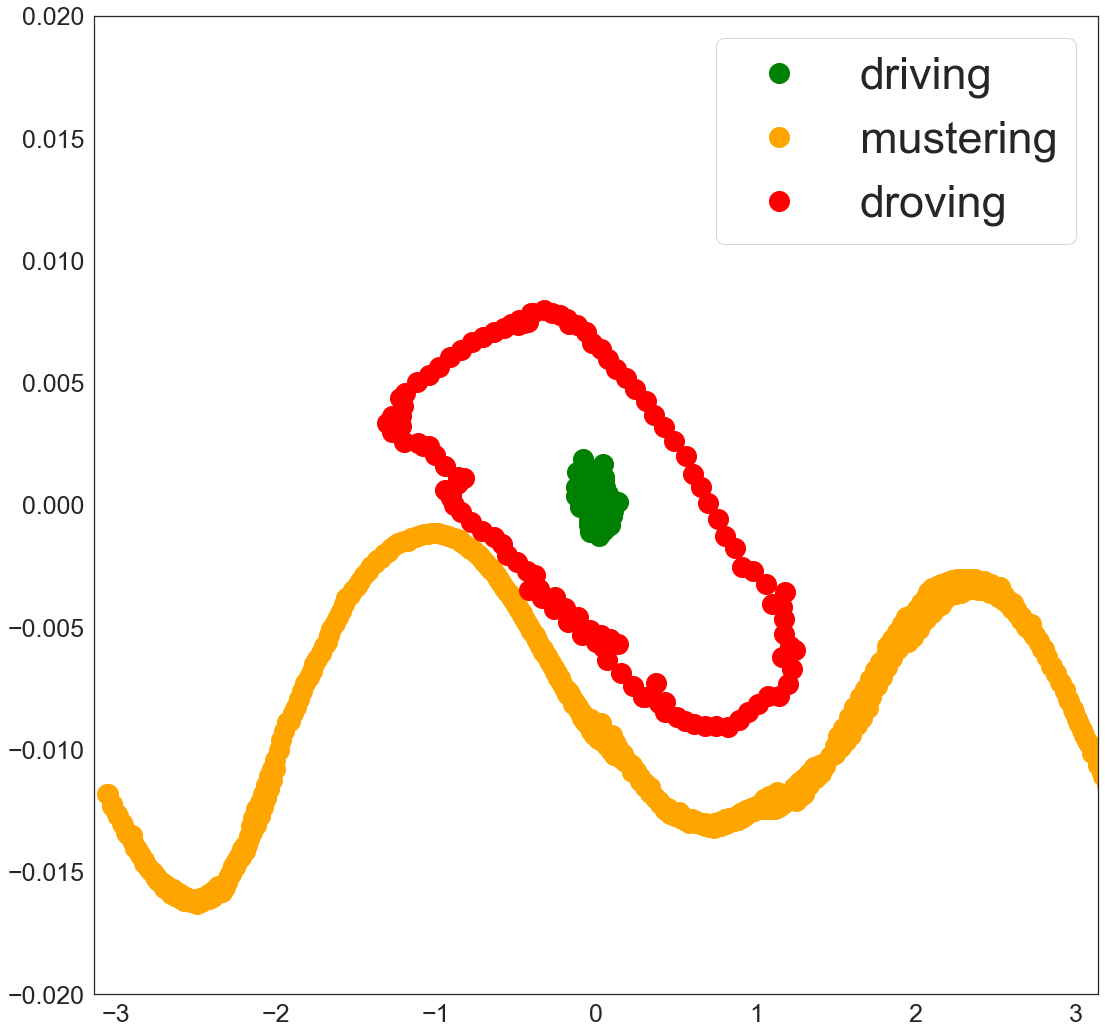

In [9]:
#windowed averaging--droving

window_length_d = 25
drove_sp = 190
drove_sl = 120
tmp_drove_dtheta = np.zeros(drove_sl)
for kk in range(drove_sl):
    start_sequence = drove_sp+kk
    tmp_drove_dtheta[kk] = np.average(droving_dtheta_1_stored[start_sequence: start_sequence+window_length_d])

    
#windowed averaging--mustering
window_length_m = 50
must_sp = 5000
must_sl = 500
tmp_must_dtheta = np.zeros(must_sl)
for kk in range(must_sl):
    start_sequence = must_sp+kk
    tmp_must_dtheta[kk] = np.average(mustering_dtheta_1_stored[start_sequence: start_sequence+window_length_m])

#windowed averaging--driving
window_length_DR = 40
drive_sp = 400
drive_sl = 200
tmp_drive_dtheta = np.zeros(drive_sl)
for kk in range(drive_sl):
    start_sequence = drive_sp+kk
    tmp_drive_dtheta[kk] = np.average(driving_dtheta_1_stored[start_sequence: start_sequence+window_length_DR])



plt.figure(figsize = (18,18))
#plt.title('$ \dot \Theta$ vs $\Theta$')

ls_all = 0.3

must_shift = np.average((mustering_theta_1_stored[must_sp:must_sp+must_sl]))
print("must_shift:" , must_shift)
drove_shift = 0*np.average(droving_theta_1_stored[drove_sp:drove_sp+drove_sl])
print("drove_shift: ", drove_shift)
drive_shift = np.average(driving_theta_1_stored[drive_sp:drive_sp+drive_sl])
print("drive_shift: ", drive_shift)

plt.plot(driving_theta_1_stored[drive_sp:drive_sp+drive_sl]-drive_shift, ls_all/3.0*tmp_drive_dtheta/0.2, 'o', label = 'driving', markersize = 20, color = 'green') #driving case 1
#plt.plot(driving_theta_1_stored[drive_sp:drive_sp+drive_sl]-drive_shift, ls_all/3.0*driving_dtheta_1_stored/0.2, '.', label = 'driving') #driving case 1



plt.plot(mustering_theta_1_stored[must_sp:must_sp+must_sl]-must_shift, ls_all*tmp_must_dtheta/0.4, 'o', label = 'mustering', markersize = 20, color = 'orange')
#plt.plot(mustering_theta_1_stored[must_sp:must_sp+must_sl]-must_shift, ls_all*mustering_dtheta_1_stored[5000:6000]/0.4, '.', label = 'mustering', markersize = 10)

plt.plot((droving_theta_1_stored[drove_sp:drove_sp+drove_sl])%(2*np.pi)-(np.pi+drove_shift), ls_all*tmp_drove_dtheta/1.3, 'o', label = 'droving', markersize = 20, color = 'red') #droving
#plt.plot((droving_theta_1_stored[200:330])%(2*np.pi)-(np.pi+drove_shift), ls_all*droving_dtheta_1_stored[200:330]/1.3, '.-', label = 'droving', markersize = 10) #droving  
#plt.plot(droving_theta_1_stored[:] - drove_shift, ls_all*droving_dtheta_1_stored[:]/1.3, '.', label = 'droving') #droving 


plt.legend(fontsize=45)
#plt.title("Angular Velocity vs Average Herd Orientation", fontsize = 35)
#plt.xlabel("$\Theta$", fontsize=40)
#plt.ylabel("$ \dot \Theta$", fontsize=40)
#plt.ylabel("$\omega_{rot}$", fontsize=30)
plt.ylim(-0.02, 0.02)
plt.xlim(-1*np.pi, 1*np.pi)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig("/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/paper_outputs/SI_ABM_videos/combined_theta_vs_thetadot_2.png")
plt.show()

In [518]:
!open "/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/SI_videos/combined_theta_vs_thetadot_2.png"

OLD STUFF BELOW!!!

In [281]:
# #testing testing testing

# max_time = 200

# y = np.zeros(max_time)
# dY = np.zeros(max_time)
# yComplex = np.zeros((max_time,2))
# dYComplex = np.zeros((max_time,2))
# y_dot = np.zeros(max_time)
# for i in range(max_time):
#     y[i] = (y[i-1]+0.05*np.sin(np.pi*i/100))
#     dY[i] = 0.05*i
#     yComplex[i, 0] = np.cos(y[i])
#     yComplex[i,1] = np.sin(y[i])
#     dYComplex[i, :] = yComplex[i,:] - yComplex[i-1,:]

    
#     y_dot[i] = dYComplex[i,1]*yComplex[i,0]-dYComplex[i,0]*yComplex[i,1]
    
# #     y_dot[i] = np.linalg.norm(dYComplex[i]/yComplex[i])
# plt.figure(figsize = (5,5))
# plt.plot((np.arctan2(yComplex[:,1], yComplex[:,0])+2*np.pi)%(2.0*np.pi), y_dot, '.')
# #plt.plot(y,y_dot, '.')
# #plt.plot(y)
# #plt.plot(y%(2*np.pi))
# plt.show()

# print(y_dot)

In [268]:
#set_up_directories
parent_folder = '/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/SI_videos/'
sub_folders = ['droving_slow', 'mustering_slow', 'driving']
archived_sub_folders = ['droving', 'mustering']
change_dir_to = parent_folder + sub_folders[1]
os.chdir(change_dir_to)

In [269]:
#load the parameter files

L = 6 #size of domain to plot
dt = 0.05 #manually setting the timestep size (should eventually be grabbed from load_params_auto)

#start timing
t0 = time.time()

#import data files
dat_field = np.loadtxt('data.txt') #x,y position data for herd and dogs
#dat_field = np.loadtxt('driving_data_SIVid.txt') #x,y position data for herd and dogs

#load info from parameter file
driving_on, x_target, y_target, vs, vd, ls, ld, fence, num_particles, ndogs, modder = load_params_auto('params.txt')

#load info from data file
xpart, ypart, thetapart, x_dogs, y_dogs, dat_times, timesteps, times, = load_data(dat_field, num_particles)


#sanity checks
sanity_checks(dat_field, num_particles, ndogs, timesteps)

#temporary function to load the data from the costdata file
costdata_full_array = np.loadtxt('costdata.txt')
l4_norm  = costdata_full_array[:,3]

Looking at data & performing sanity checks...
There are  100 sheep!
There are  1 dogs!
There are 9759 frames of dumped data!


In [271]:
#convert from theta to e^itheta

tComplex = np.zeros((len(thetapart), 2))
tComplex_avg = np.zeros((timesteps, 2))
dtComplex_avg = np.zeros((timesteps, 2))
Theta_extract_avg = np.zeros(timesteps)
ThetaDot_extract_avg = np.zeros(timesteps)

#setup complex theta_arrays
for pp in range(len(thetapart)):
    tComplex[pp,0] = np.cos(thetapart[pp])
    tComplex[pp,1] = np.sin(thetapart[pp])

#take the average of theta over the agents
for kk in range(timesteps):
    index = num_particles*kk
    temp_theta_Complex = tComplex[index:index+num_particles, :]
    tComplex_avg[kk, :] = np.array([np.average(temp_theta_Complex[:,0]), 
                                    np.average(temp_theta_Complex[:,1])])
    dtComplex_avg[kk] = tComplex_avg[kk] - tComplex_avg[kk-1]

    #extract theta and theta-dot
    Theta_extract_avg[kk] = np.arctan2(tComplex_avg[kk, 1], tComplex_avg[kk, 0])#%(2*np.pi)
    
    ThetaDot_extract_avg[kk] = dtComplex_avg[kk,1]*tComplex_avg[kk, 0]
    -dtComplex_avg[kk, 0]*tComplex_avg[kk,1]

In [272]:
filter_Theta_extract_avg = savgol_filter(Theta_extract_avg, 51, 3)
filter_ThetaDot_extract_avg = savgol_filter(ThetaDot_extract_avg, 51, 3)

In [273]:
# plt.figure(figsize = (10,10))
# plt.plot(tComplex_avg[:,0], tComplex_avg[:,1])
# plt.show()

In [274]:
# plt.figure(figsize = (10,10))
# plt.hist(Theta_extract_avg)
# #plt.plot(times, Theta_extract_avg, '.')
# #plt.plot(times, tComplex_avg[:,1])
# plt.show()

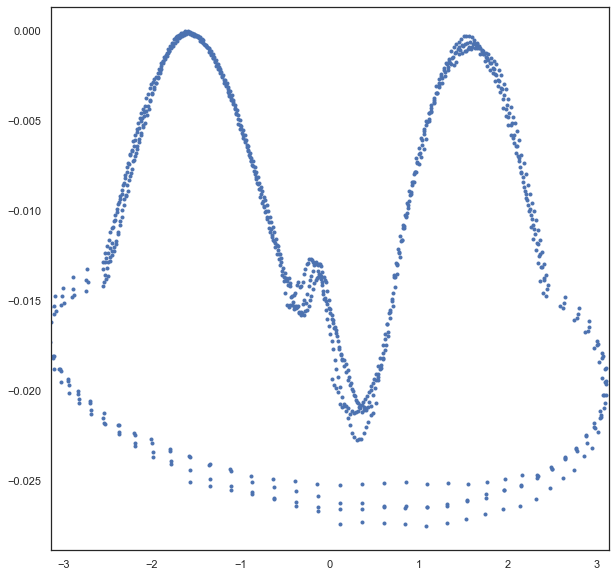

In [280]:
plt.figure(figsize = (10,10))
#plt.plot((Theta_extract_avg+2*np.pi)%(2*np.pi), ThetaDot_extract_avg, '--')
#plt.plot((Theta_extract_avg[400:600]+2*np.pi)%(2*np.pi), ThetaDot_extract_avg[400:600], '--') #droving
#plt.plot((filter_Theta_extract_avg[400:600]), filter_ThetaDot_extract_avg[400:600], '--') #droving
#plt.plot((filter_Theta_extract_avg[100:300]), filter_ThetaDot_extract_avg[100:300], '--') #driving
plt.plot((filter_Theta_extract_avg[5000:6000]), filter_ThetaDot_extract_avg[5000:6000], '.') #mustering

plt.xlim(-np.pi, np.pi)
plt.show()

In [293]:
#convert from mod to total angle
thetapart_tmp = np.array(thetapart)

thetapart_total = np.zeros((num_particles, timesteps))

for pp in range(num_particles):
    tmp_particle_storer = thetapart_tmp[pp::num_particles]
    for kk in range(1, timesteps):
        if tmp_particle_storer[kk]-tmp_particle_storer[kk-1] > np.pi:
            #print("subtracted at time ", kk)
            tmp_particle_storer[kk-1:]= tmp_particle_storer[kk-1:]-2*np.pi
        if tmp_particle_storer[kk]-tmp_particle_storer[kk-1] < -1.0*np.pi:
            #print("added at time ", kk)
            tmp_particle_storer[kk-1:]= tmp_particle_storer[kk-1:]+2*np.pi
    
    thetapart_total[pp,:] = tmp_particle_storer

In [16]:
# #extract total angle for dog positions
# theta_dog = np.zeros(timesteps)
# for ii in range(len(times)-1):
#     index = ii*num_particles
#     theta_dog[ii+1] = np.arctan2(y_dogs[index+num_particles]-y_dogs[index], x_dogs[index+num_particles]-x_dogs[index])

    
# filtered_theta_dog = savgol_filter(theta_dog, 51, 3)
    
# theta_dog = (theta_dog)
# plt.figure(figsize = (12,8))
# plt.plot(times, theta_dog, '--')
# plt.plot(times, filtered_theta_dog, 'r-')
# plt.show()

In [296]:
avg_polarization_1 = np.zeros(timesteps)
std_polarization_1 = np.zeros(timesteps)
delta_polarization_1 = np.zeros(timesteps)
avg_polarization_cos = np.zeros(timesteps)
std_polarization_cos = np.zeros(timesteps)
delta_polarization_cos = np.zeros(timesteps)

avg_polarization_complex = [] #np.zeros(timesteps)
avg_polarization_complex.append(0 +0j)
delta_polarization_complex = [] #np.zeros(timesteps)
delta_polarization_complex.append(0 +0j)

modder = 1

counterr = 0
for t in range(1,timesteps):
#for t in range(10):

#fork here
#for t in range(0,100):
    if t%modder == 0:
        counterr +=1
        
        #download particle data
        index = num_particles*t
        tmp_x = xpart[index: index+num_particles]
        tmp_y = ypart[index: index+num_particles]
        #tmp_theta = thetapart[index: index+num_particles]
        tmp_theta = thetapart_total[:, t]
        tmp_theta_complex = np.array([cmath.exp(thetapart[index+ii]*1j) for ii in range(num_particles)])
        
        
        #calculate the angle between the target and the dog (ONLY FOR 1 DOG)
        tmp_target_angle = np.arctan2(y_target-y_dogs[index,0], x_target-x_dogs[index,0])
        # set color info
        tmp_colors = (tmp_theta - tmp_target_angle)%(2*np.pi) #colorator(tmp_theta)
        
        
#         #find complex average components
#         avg_complex_real_theta = 
        
        avg_polarization_1[t] = np.average(tmp_theta)
        avg_polarization_cos[t] = np.average(np.cos(tmp_theta))
        avg_polarization_complex.append(np.average(tmp_theta_complex))
        std_polarization_1[t] = np.std(tmp_theta)
        delta_polarization_1[t] = (avg_polarization_1[t]-avg_polarization_1[t-1])
        delta_polarization_cos[t] = (avg_polarization_cos[t]-avg_polarization_cos[t-1])
        delta_polarization_complex.append((avg_polarization_complex[t]-avg_polarization_complex[t-1]))

delta_polarization_complex 
        
        

error_up = avg_polarization_1 + 2.0*std_polarization_1
error_down = avg_polarization_1 - 2.0*std_polarization_1
        
#plt.figure(figsize = (10,8))
#plt.plot(avg_polarization_cos[10:], delta_polarization_cos[10:], '--')
#plt.plot(np.arccos(avg_polarization_1), np.arccos(delta_polarization_1), '--')

In [283]:
# plt.figure(figsize = (10,8))
# #plt.plot(np.abs(avg_polarization_complex)[8000:9000], np.abs(delta_polarization_complex)[8000:9000])
# plt.plot(np.abs(avg_polarization_complex), np.abs(delta_polarization_complex))
# #plt.xlim(0.95,1)
# #plt.ylim(0,0.05)
# #plt.plot(complex_filtered_theta_avg, complex_filtered_dtheta_avg)
# plt.show()

In [297]:
from scipy.signal import savgol_filter
filtered_theta_avg = savgol_filter(avg_polarization_1, 51, 3)
filtered_dtheta_avg = savgol_filter([filtered_theta_avg[kk]-filtered_theta_avg[kk-1] for kk in range(len(filtered_theta_avg))], 101, 3)

In [298]:
!open .

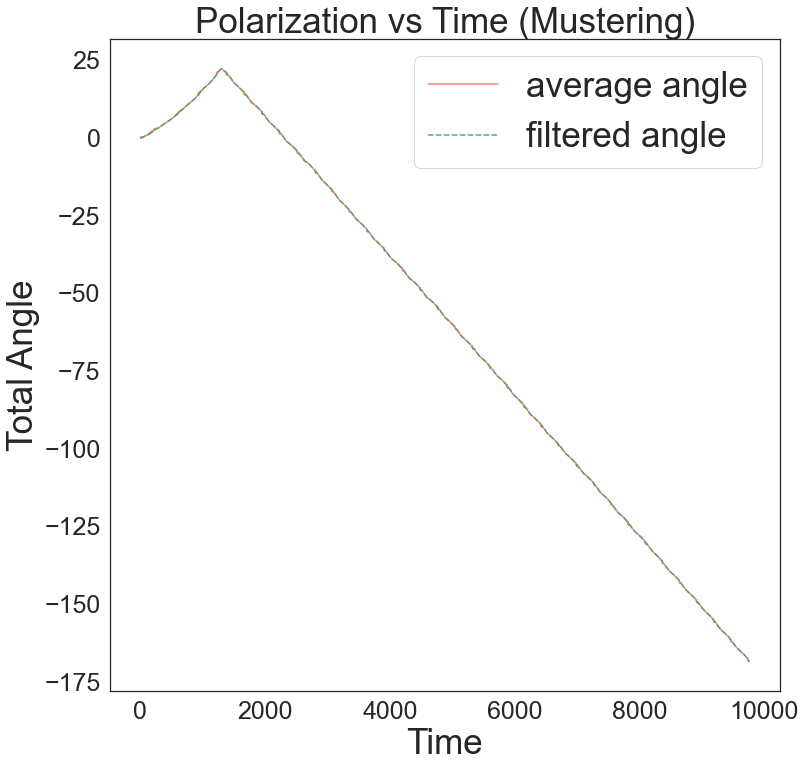

In [299]:
plt.figure(figsize = (12,12))
plt.title("Polarization vs Time (Mustering)", fontsize = 35)
plt.ylabel("Total Angle", fontsize = 35)
plt.xlabel("Time", fontsize = 35)
# plt.plot(times, error_up)
# plt.plot(times, error_down)
#plt.fill_between(times, error_down, error_up, alpha=0.5, edgecolor='k', facecolor='#7EFF99', label = '2 std bound')
plt.plot(times, avg_polarization_1,'red', label = 'average angle', alpha = 0.5)#
#plt.plot(times, avg_polarization_1, 'red', label = 'average angle')#
#plt.plot(times, avg_polarization_smooth, '.', 'green', label = 'total average angle')
#plt.plot(times, delta_polarization_1, 'blue', label = 'delta polarization')
plt.plot(times, filtered_theta_avg, 'g--', label = 'filtered angle')
#plt.plot(times, filtered_dtheta_avg, 'c--', label = 'delta polarization')
#plt.xlim(50,100)
#plt.ylim(-2*np.pi, 2*np.pi)
#plt.xlim(4700, 4900)
#plt.ylim(-60,-50)
#plt.ylim()
plt.legend(fontsize = 35)
plt.savefig("polarization_vs_time_mustering.png")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.savefig("total_avg_angle_droving.png")
#plt.savefig('total_avg_angle_mustering.png')
plt.show()

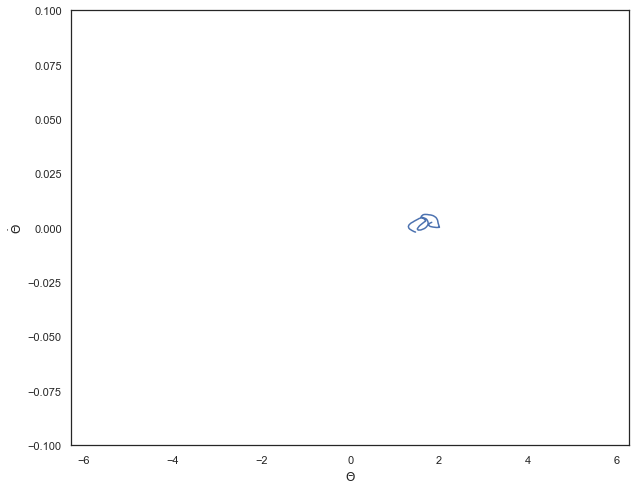

In [246]:
plt.figure(figsize = (10,8))
plt.xlabel("$\Theta$")
plt.ylabel("$ \dot \Theta$")
#plt.plot(filtered_theta_avg[100:-100], filtered_dtheta_avg[100:-100])
#plt.plot(filtered_theta_avg[100:1000], filtered_dtheta_avg[100:1000]) #mustering case 1
plt.plot(filtered_theta_avg[100:300], filtered_dtheta_avg[100:300]) #driving case 1
#plt.plot(np.fmod(filtered_theta_avg[600:1000], np.pi), filtered_dtheta_avg[600:1000]) #driving case 2
#plt.plot(np.fmod(-1*filtered_theta_avg[6000:6300], 2*np.pi), filtered_dtheta_avg[6000:6300], '.') #mustering case 2
#plt.plot(filtered_theta_avg[400:600], filtered_dtheta_avg[400:600], '.') #droving--good case 1
#plt.plot(filtered_theta_avg[1100:1250], filtered_dtheta_avg[1100:1250])
plt.ylim(-0.1, 0.1)
plt.xlim(-2*np.pi, 2*np.pi)
#plt.ylim(-0.01,0.01)
#plt.xlim(-100, -50)
#plt.xlim(4700, 4900)
#plt.plot(avg_polarization_1, delta_polarization_1,'--')
plt.savefig("theta_vs_thetadot_1.png")

### Create Combined Plot for Fig. 3

In [247]:
#store the good data for use in the combined plots--MUSTERING ONLY
driving_theta_1_stored = filtered_theta_avg #filtered_theta_avg[100:300]
driving_dtheta_1_stored = filtered_dtheta_avg #filtered_dtheta_avg[100:300]

In [233]:
#store the good data for use in the combined plots--MUSTERING ONLY
mustering_theta_1_stored = filtered_theta_avg #np.fmod(-1*filtered_theta_avg[6000:6300], 2*np.pi)
mustering_dtheta_1_stored = filtered_dtheta_avg #filtered_dtheta_avg[6000:6300]

In [219]:
#store the good data for use in the combined plots--DROVING ONLY
droving_theta_1_stored = filtered_theta_avg[400:600]
droving_dtheta_1_stored = filtered_dtheta_avg[400:600]

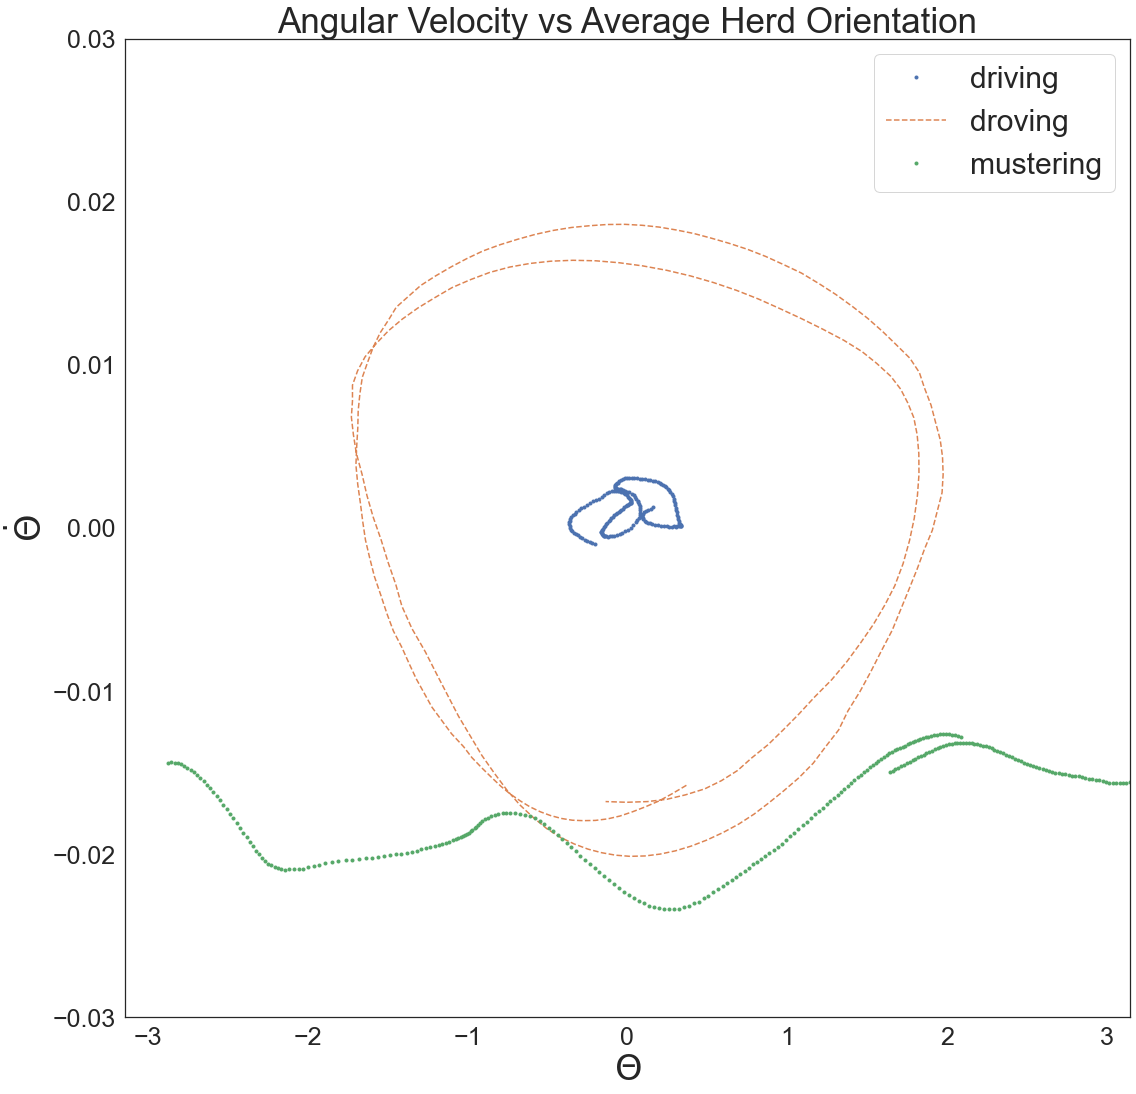

In [302]:
plt.figure(figsize = (18,18))
#plt.title('$ \dot \Theta$ vs $\Theta$')

ls_all = 0.3

must_shift = np.average(np.fmod(-1*mustering_theta_1_stored[6001:6299], 2*np.pi))
drove_shift = np.average(droving_theta_1_stored)
drive_shift = np.average(driving_theta_1_stored[100:300])

plt.plot(driving_theta_1_stored[100:300]-drive_shift, ls_all/3.0*driving_dtheta_1_stored[100:300]/0.2, '.', label = 'driving') #driving case 1
plt.plot(droving_theta_1_stored - drove_shift, ls_all*droving_dtheta_1_stored/1.3, '--', label = 'droving') #droving
plt.plot(np.fmod(-1*mustering_theta_1_stored[6001:6299]+np.pi, 2*np.pi)-must_shift, ls_all*mustering_dtheta_1_stored[6001:6299]/0.4, '.', label = 'mustering') 




plt.legend(fontsize=30)
plt.title("Angular Velocity vs Average Herd Orientation", fontsize = 35)
plt.xlabel("$\Theta$", fontsize=35)
plt.ylabel("$ \dot \Theta$", fontsize=35)
plt.ylim(-0.03, 0.03)
plt.xlim(-1*np.pi, 1*np.pi)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig("combined_theta_vs_thetadot_1.png")
plt.show()

In [253]:
!pwd

/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/SI_videos/driving


## Extra Stuff Below

In [ ]:
!open .

In [ ]:
print(timesteps)
plt.figure(figsize = (10,8))
plt.plot(delta_polarization_smooth)
plt.plot(filtered_dtheta_avg)

In [ ]:
print(np.max(delta_polarization_1), np.argmax(delta_polarization_1))
print(np.min(delta_polarization_1), np.argmin(delta_polarization_1))

In [ ]:
print(avg_polarization_1[np.argmax(delta_polarization_1)-2:np.argmax(delta_polarization_1)+2])
print(avg_polarization_1[np.argmin(delta_polarization_1)-2:np.argmin(delta_polarization_1)+2])

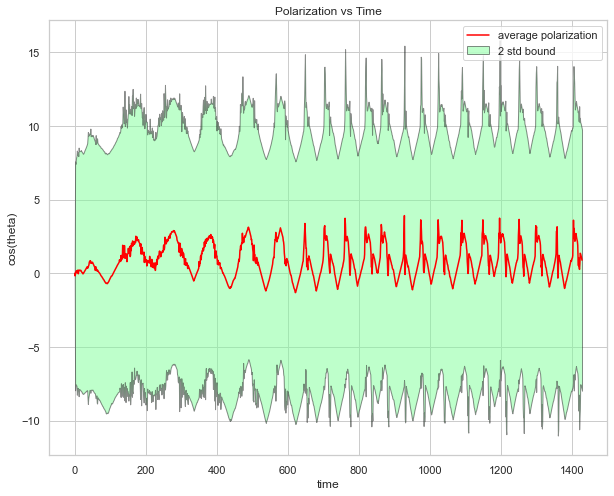

In [17]:
# avg_polarization_1 = np.zeros(timesteps)
# std_polarization_1 = np.zeros(timesteps)
# delta_polarization_1 = np.zeros(timesteps)
# modder = 1

# counterr = 0
# for t in range(timesteps):
# #for t in range(10):

# #fork here
# #for t in range(0,100):
#     if t%modder == 0:
#         counterr +=1
        
#         #download particle data
#         index = num_particles*t
#         tmp_x = xpart[index: index+num_particles]
#         tmp_y = ypart[index: index+num_particles]
#         tmp_theta = thetapart[index: index+num_particles]
        
        
#         #calculate the angle between the target and the dog (ONLY FOR 1 DOG)
#         tmp_target_angle = np.arctan2(y_target-y_dogs[index,0], x_target-x_dogs[index,0])
#         # set color info
#         tmp_colors = (tmp_theta - tmp_target_angle)%(2*np.pi) #colorator(tmp_theta)
        
#         avg_polarization_1[t] = np.average(tmp_theta) #np.average(np.cos(tmp_theta)) #np.average(tmp_colors) #np.average(tmp_theta)
#         std_polarization_1[t] = np.std(np.cos(tmp_theta))

        


# error_up = avg_polarization_1 + 2.0*std_polarization_1
# error_down = avg_polarization_1 - 2.0*std_polarization_1
        
plt.figure(figsize = (10,8))
plt.title("Polarization vs Time")
plt.ylabel("cos(theta)")
plt.xlabel("time")
# plt.plot(times, error_up)
# plt.plot(times, error_down)
plt.fill_between(times, error_down, error_up, alpha=0.5, edgecolor='k', facecolor='#7EFF99', label = '2 std bound')
plt.plot(times, avg_polarization_1, 'red', label = 'average polarization')
plt.legend()
plt.show()

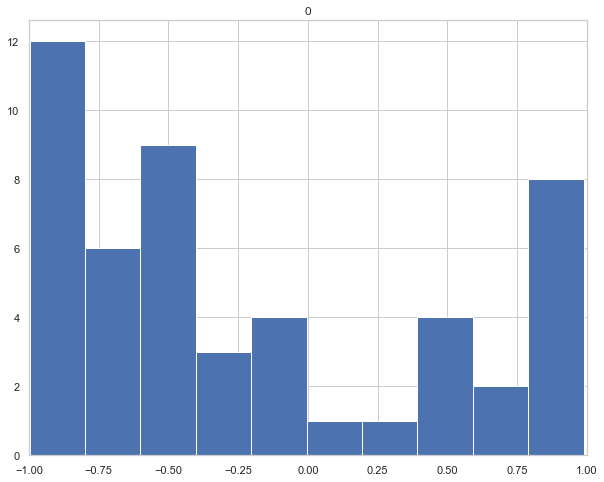

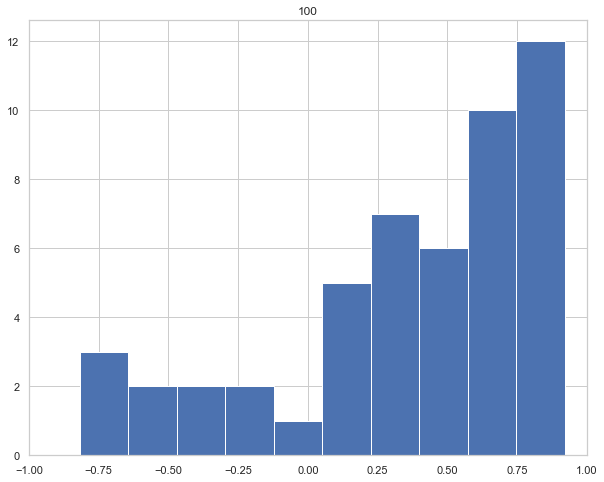

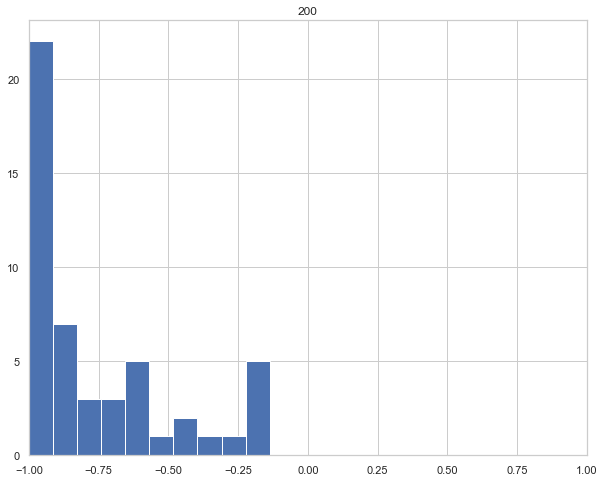

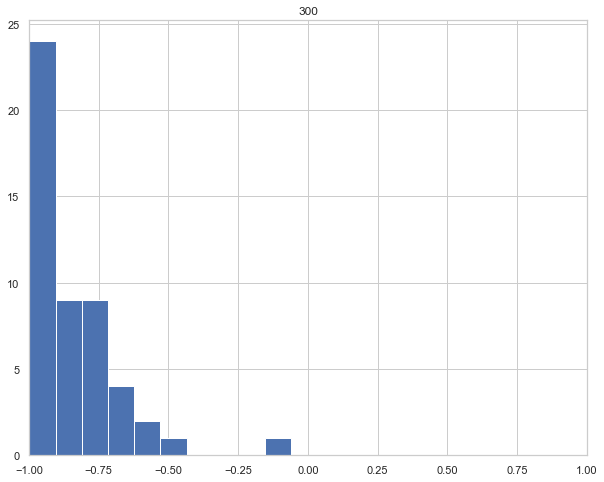

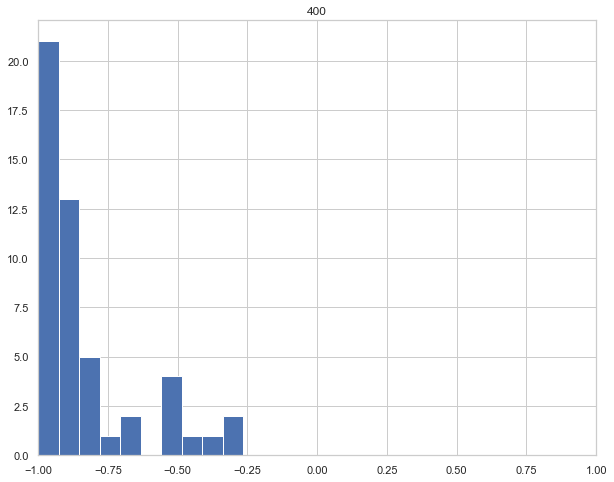

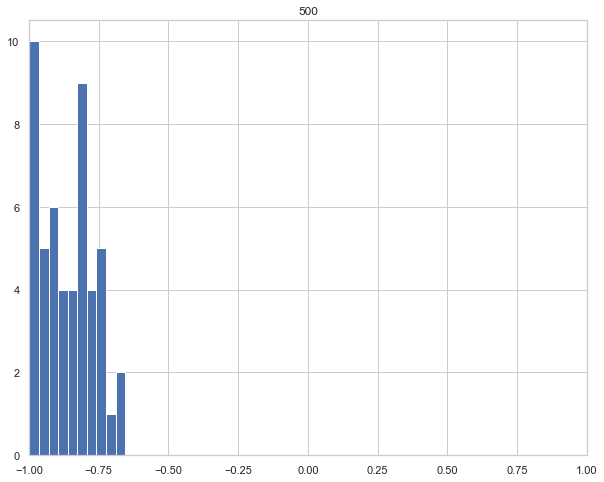

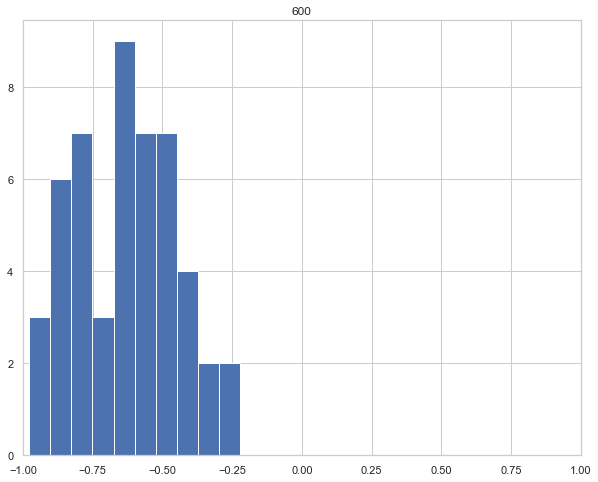

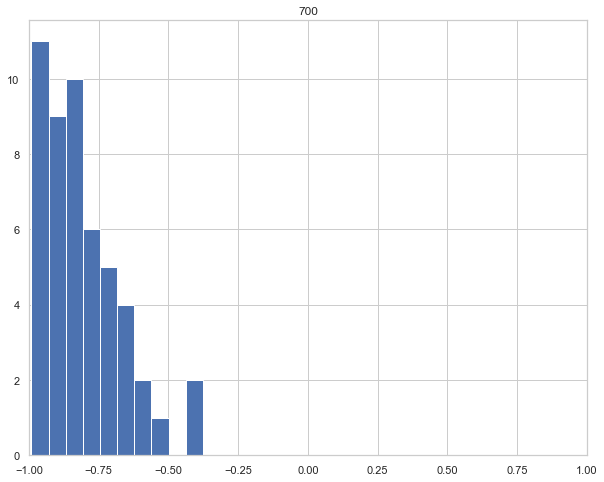

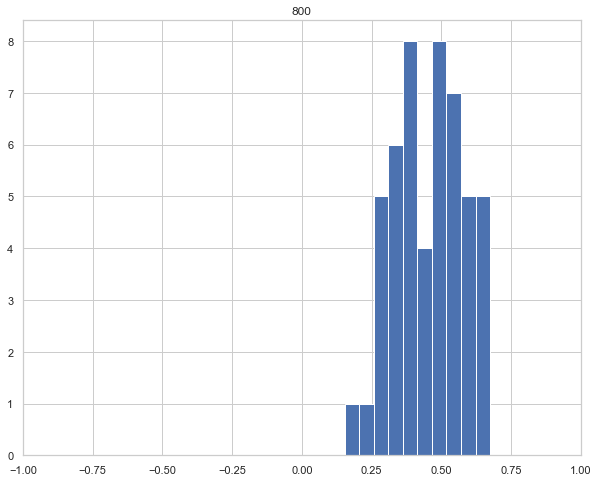

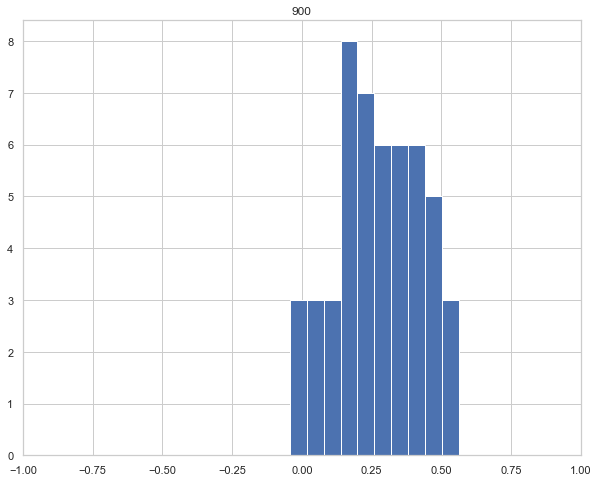

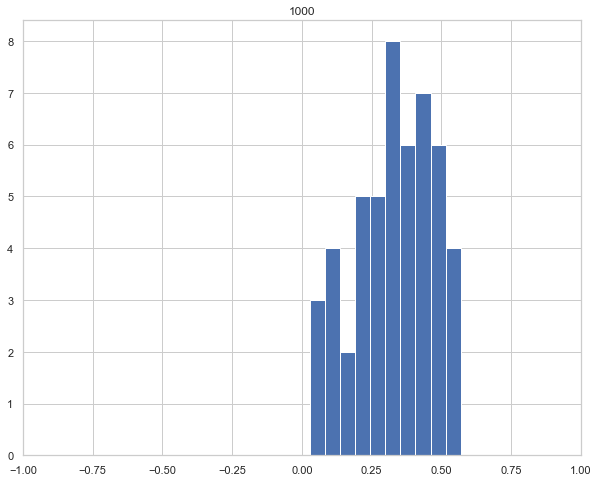

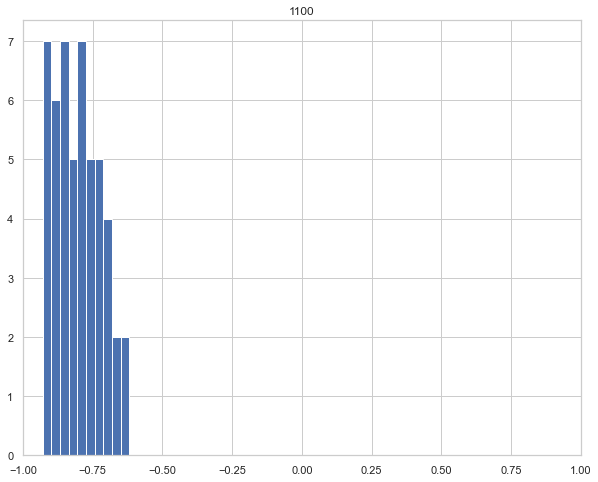

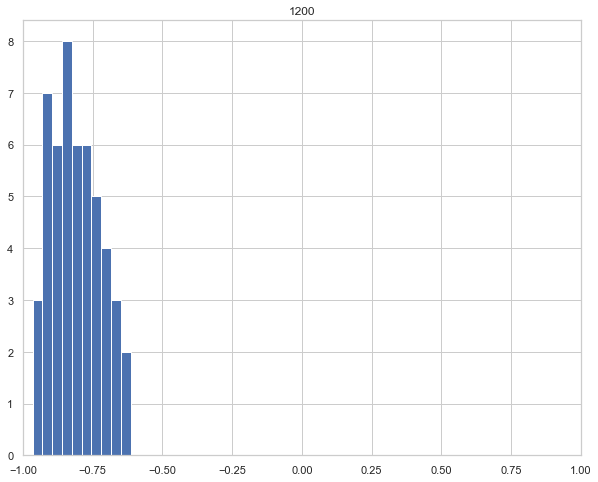

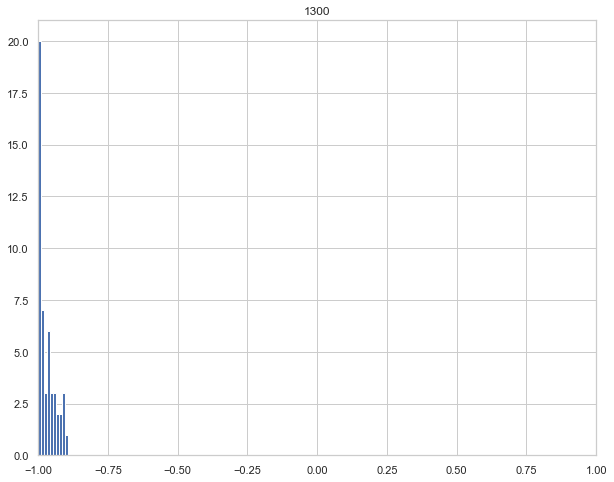

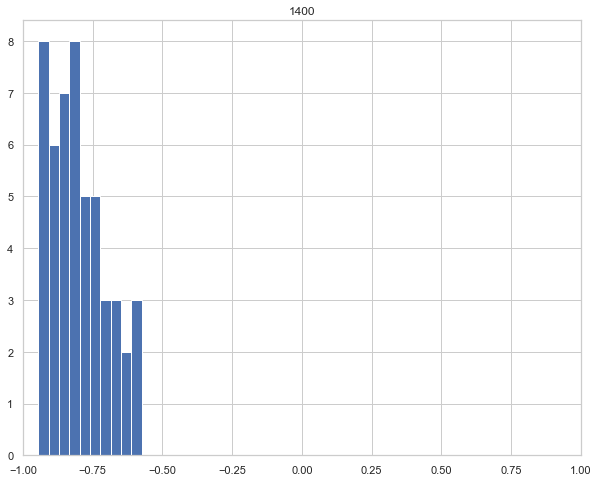

In [19]:
avg_polarization_1 = np.ones(timesteps)
modder = 100

counterr = 0
for t in range(timesteps):
#for t in range(10):

#fork here
#for t in range(1000, 1030):
    if t%modder == 0:
        counterr +=1
        
        #download particle data
        index = num_particles*t
        tmp_x = xpart[index: index+num_particles]
        tmp_y = ypart[index: index+num_particles]
        tmp_theta = thetapart[index: index+num_particles]
        
        
        #calculate the angle between the target and the dog (ONLY FOR 1 DOG)
        tmp_target_angle = np.arctan2(y_target-y_dogs[index,0], x_target-x_dogs[index,0])
        # set color info
        tmp_colors = (tmp_theta - tmp_target_angle)%(2*np.pi) #colorator(tmp_theta)
        
        avg_polarization_1[t] = np.average(tmp_theta) #np.average(tmp_colors) #np.average(tmp_theta)
        
        plt.figure(figsize = (10,8))
        plt.title(t)
        plt.hist(np.cos(tmp_theta))
        plt.xlim(-1,1)
        #plt.xlim(0, 2*np.pi)
        plt.show()
        
# plt.figure(figsize = (10,8))
# plt.plot(times, avg_polarization_1, '.')